# RoboND - KUKA KR210 Forward and Inverse Kinematics

Jun Zhu

In [1]:
from __future__ import print_function

from IPython.display import Image
import numpy as np
from sympy import symbols, pi, sin, cos, sqrt, atan2, simplify
from sympy.matrices import Matrix

from tf.transformations import euler_from_quaternion

## KUKA KR210 

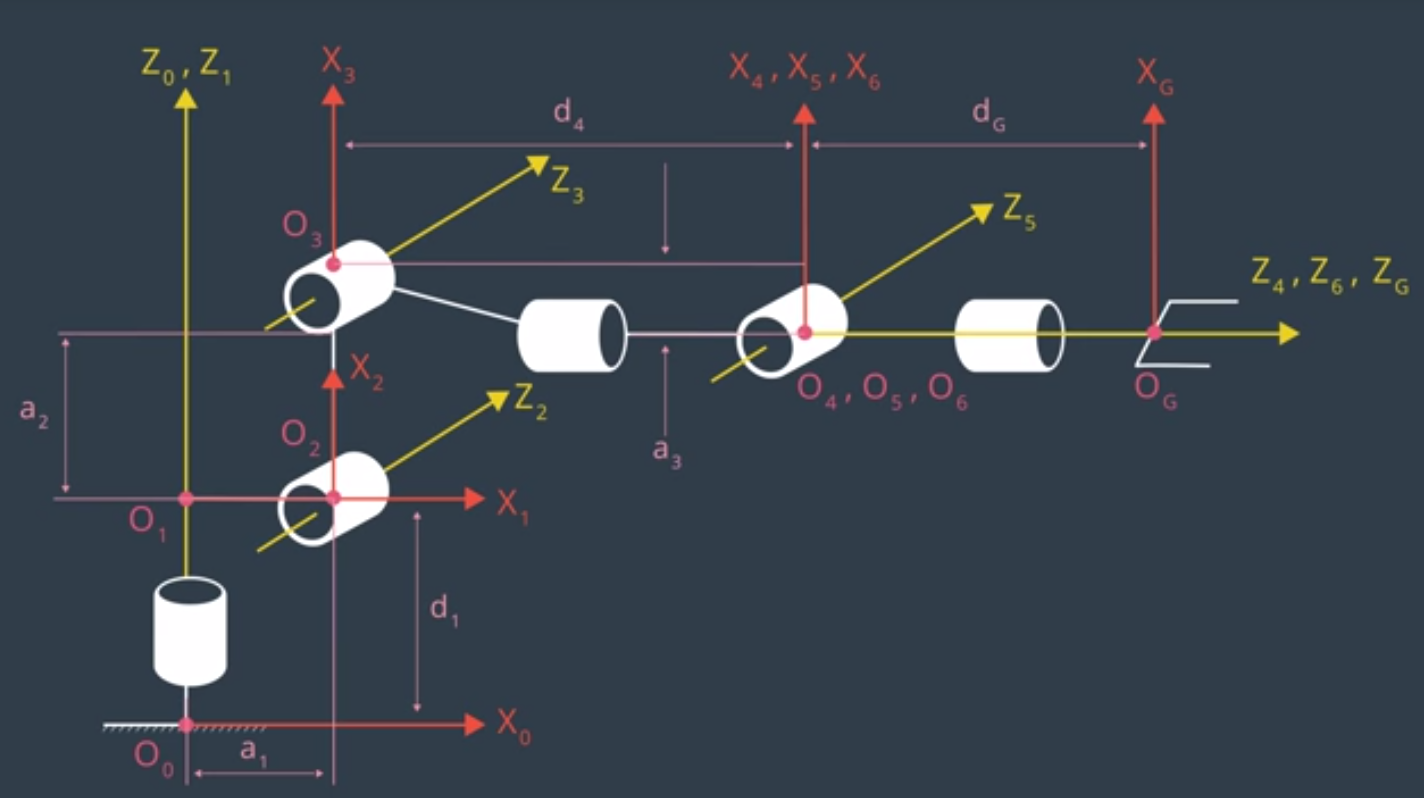

In [2]:
Image(filename='misc_images/coordinate_frame.png') 

The constants below (distance between joints) are derived from the file [kr210.urdf.xacro](kuka_arm/urdf/kr210.urdf.xacro).

In [3]:
# define constants
D1 = 0.75
A1 = 0.35
A2 = 1.25
A3 = 0.054
D4 = 1.500
# In ROS, DG should increase by 0.15, which is the distance from 
# the gripper link to the gripper finger. A longer DG chould avoid
# collision between the gripper and the target
DG = 0.303  

In [4]:
# create symbols for DH parameters
theta1, theta2, theta3, theta4, theta5, theta6, theta7 = symbols('theta1:8')
d1, d2, d3, d4, d5, d6, d7 = symbols('d1:8')
alpha0, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6 = symbols('alpha0:7')
a0, a1, a2, a3, a4, a5, a6 = symbols('a0:7')

# DH parameters for KUKA KR210
#
# For examples:
# alpha1: angle from Z1 to Z2 measured about X1 following the right-hand-rule, which is -pi/2.
# a1: distance from Z1 to Z2 measured along X1, which is a1
# d2: distance from X1 to X2 measured along Z2, which is 0
# theta2: angle from X1 to X2 measured about Z2 following the right-hand-rule, which is -pi/2 
#         plus the rotation of joint 2
#
dh_params = {alpha0:     0,  a0:   0,  d1:  D1,
             alpha1: -pi/2,  a1:  A1,  d2:   0, theta2: theta2 - pi/2,
             alpha2:     0,  a2:  A2,  d3:   0,
             alpha3: -pi/2,  a3: -A3,  d4:  D4,
             alpha4:  pi/2,  a4:   0,  d5:   0,
             alpha5: -pi/2,  a5:   0,  d6:   0,
             alpha6:     0,  a6:   0,  d7:  DG, theta7:             0}


T0_1 = Matrix([[            cos(theta1),            -sin(theta1),            0,              a0],
               [sin(theta1)*cos(alpha0), cos(theta1)*cos(alpha0), -sin(alpha0), -sin(alpha0)*d1],
               [sin(theta1)*sin(alpha0), cos(theta1)*sin(alpha0),  cos(alpha0),  cos(alpha0)*d1],
               [                      0,                       0,              0,             1]])
T0_1 = T0_1.subs(dh_params)

T1_2 = Matrix([[            cos(theta2),            -sin(theta2),            0,              a1],
               [sin(theta2)*cos(alpha1), cos(theta2)*cos(alpha1), -sin(alpha1), -sin(alpha1)*d2],
               [sin(theta2)*sin(alpha1), cos(theta2)*sin(alpha1),  cos(alpha1),  cos(alpha1)*d2],
               [                      0,                       0,              0,             1]])
T1_2 = T1_2.subs(dh_params)

T2_3 = Matrix([[            cos(theta3),            -sin(theta3),            0,              a2],
               [sin(theta3)*cos(alpha2), cos(theta3)*cos(alpha2), -sin(alpha2), -sin(alpha2)*d3],
               [sin(theta3)*sin(alpha2), cos(theta3)*sin(alpha2),  cos(alpha2),  cos(alpha2)*d3],
               [                      0,                       0,              0,             1]])
T2_3 = T2_3.subs(dh_params)

T3_4 = Matrix([[            cos(theta4),            -sin(theta4),            0,              a3],
               [sin(theta4)*cos(alpha3), cos(theta4)*cos(alpha3), -sin(alpha3), -sin(alpha3)*d4],
               [sin(theta4)*sin(alpha3), cos(theta4)*sin(alpha3),  cos(alpha3),  cos(alpha3)*d4],
               [                      0,                       0,              0,             1]])
T3_4 = T3_4.subs(dh_params)

T4_5 = Matrix([[            cos(theta5),            -sin(theta5),            0,              a4],
               [sin(theta5)*cos(alpha4), cos(theta5)*cos(alpha4), -sin(alpha4), -sin(alpha4)*d5],
               [sin(theta5)*sin(alpha4), cos(theta5)*sin(alpha4),  cos(alpha4),  cos(alpha4)*d5],
               [                      0,                       0,              0,             1]])
T4_5 = T4_5.subs(dh_params)

T5_6 = Matrix([[            cos(theta6),            -sin(theta6),            0,              a5],
               [sin(theta6)*cos(alpha5), cos(theta6)*cos(alpha5), -sin(alpha5), -sin(alpha5)*d6],
               [sin(theta6)*sin(alpha5), cos(theta6)*sin(alpha5),  cos(alpha5),  cos(alpha5)*d6],
               [                      0,                       0,              0,             1]])
T5_6 = T5_6.subs(dh_params)

T6_G = Matrix([[            cos(theta7),            -sin(theta7),            0,              a6],
               [sin(theta7)*cos(alpha6), cos(theta7)*cos(alpha6), -sin(alpha6), -sin(alpha6)*d7],
               [sin(theta7)*sin(alpha6), cos(theta7)*sin(alpha6),  cos(alpha6),  cos(alpha6)*d7],
               [                      0,                       0,              0,             1]])
T6_G = T6_G.subs(dh_params)

T0_2 = simplify(T0_1 * T1_2)
T0_3 = simplify(T0_2 * T2_3)
T0_4 = simplify(T0_3 * T3_4)
T0_5 = simplify(T0_4 * T4_5)
T0_6 = simplify(T0_5 * T5_6)
T0_G = simplify(T0_6 * T6_G)


Ry_corr = Matrix([[ cos(-pi/2), 0, sin(-pi/2), 0],
                  [          0, 1,          0, 0],
                  [-sin(-pi/2), 0, cos(-pi/2), 0],
                  [          0, 0,          0, 1]])

Rz_corr = Matrix([[cos(pi), -sin(pi), 0, 0],
                  [sin(pi),  cos(pi), 0, 0],
                  [      0,        0, 1, 0],
                  [      0,        0, 0, 1]])


# The homogeneous transform matrix from the base to the end-effector
T_total = simplify(T0_G*Rz_corr*Ry_corr)

In [5]:
# Using different theta1-6 in 'joint_state_publisher' and compare the final 
# coordinates output by using the following matrix method and RViz.
positions = {theta1: 0.35, theta2: 0.1, theta3: -0.31, theta4: 0.59, theta5: 0.59, theta6: -1.54}
             
T_total.subs(positions)

Matrix([
[ 0.747803872024226, -0.546338491587402, -0.377231522536992,  2.06126870067337],
[ 0.602484922331691,  0.319714845009447,  0.731296339552962, 0.852264916998859],
[-0.278928821294162, -0.774142538871613,  0.568244702712539,  2.16911595411945],
[                 0,                  0,                  0,                 1]])

__In the following, I will use functions to calculate the forward and inverse kinematics instead of Sympy__

__The forward and inverse kinematics models can both be tested in RViz by playing with different input parameters of the "joint_state_publisher"__
```
roslaunch kuka_arm forward_kinematics.launch
```

## Forward kinematics

In [6]:
def homogeneous_transform(alpha, a, d, theta):
    """Homogeneous transformation matrix using DH parameters"""
    return np.matrix([[np.cos(theta),               -np.sin(theta), 0, a],
                      [np.sin(theta)*np.cos(alpha), np.cos(theta)*np.cos(alpha), -np.sin(alpha), -np.sin(alpha)*d],
                      [np.sin(theta)*np.sin(alpha), np.cos(theta)*np.sin(alpha),  np.cos(alpha),  np.cos(alpha)*d],
                      [                          0,                           0,              0,                1]])


def rotation_y(theta):
    """Matrix of rotation about y axis"""
    return np.matrix([[ np.cos(theta), 0,  np.sin(theta), 0],
                      [             0, 1,              0, 0],
                      [-np.sin(theta), 0,  np.cos(theta), 0],
                      [             0, 0,              0, 1]])


def rotation_x(theta):
    """Matrix of rotation about x axis"""
    return np.matrix([[ 1,             0,              0, 0],
                      [ 0, np.cos(theta), -np.sin(theta), 0],
                      [ 0, np.sin(theta),  np.cos(theta), 0],
                      [ 0,             0,              0, 1]])


def rotation_z(theta):
    """Matrix of rotation about z axis"""
    return np.matrix([[ np.cos(theta), -np.sin(theta), 0, 0],
                      [ np.sin(theta),  np.cos(theta), 0, 0],
                      [             0,              0, 1, 0],
                      [             0,              0, 0, 1]])


def xyz_fixed_angle(gamma, beta, alpha):
    """Rotation matrix of a X-Y-Z fix angle transform"""
    return rotation_z(alpha)*rotation_y(beta)*rotation_x(gamma)


In [7]:
def get_dh_parameters(theta1=0., theta2=0., theta3=0., theta4=0., theta5=0., theta6=0.):
    """Form the DH table
    
    @params theta1, theta2, theta3, theta4, theta5, theta6: float
        Angles defined in the DH table.
        
    @return: numpy.ndarray
        DH table.
    """
    # alpha, a, d, theta
    return [[        0,   0, D1,           theta1],
            [ -np.pi/2,  A1,  0, theta2 - np.pi/2],
            [        0,  A2,  0,           theta3],
            [ -np.pi/2, -A3, D4,           theta4],
            [  np.pi/2,   0,  0,           theta5],
            [ -np.pi/2,   0,  0,           theta6],
            [        0,   0, DG,                0]]


def trans_base_link1(theta1):
    """Homogeneous transform matrix from base to link 1"""
    dh_params = get_dh_parameters(theta1)

    return homogeneous_transform(
        dh_params[0][0], dh_params[0][1], dh_params[0][2], dh_params[0][3])


def trans_base_link2(theta1, theta2):
    """Homogeneous transform matrix from base to link 2"""
    dh_params = get_dh_parameters(theta1, theta2)
    
    return np.matmul(trans_base_link1(theta1), homogeneous_transform(
        dh_params[1][0], dh_params[1][1], dh_params[1][2], dh_params[1][3]))
    
    
def trans_base_link3(theta1, theta2, theta3):
    """Homogeneous transform matrix from base to link 3"""
    dh_params = get_dh_parameters(theta1, theta2, theta3)
    
    return np.matmul(trans_base_link2(theta1, theta2), homogeneous_transform(
        dh_params[2][0], dh_params[2][1], dh_params[2][2], dh_params[2][3]))


def trans_base_link4(theta1, theta2, theta3, theta4):
    """Homogeneous transform matrix from base to link 4"""
    dh_params = get_dh_parameters(theta1, theta2, theta3, theta4)
    
    return np.matmul(trans_base_link3(theta1, theta2, theta3), 
                           homogeneous_transform(dh_params[3][0], dh_params[3][1], 
                                                 dh_params[3][2], dh_params[3][3]))
    

def trans_base_link5(theta1, theta2, theta3, theta4, theta5):
    """Homogeneous transform matrix from base to link 5"""
    dh_params = get_dh_parameters(theta1, theta2, theta3, theta4, theta5)
    
    return np.matmul(trans_base_link4(theta1, theta2, theta3, theta4), 
                           homogeneous_transform(dh_params[4][0], dh_params[4][1], 
                                                 dh_params[4][2], dh_params[4][3]))
    
    
def trans_base_link6(theta1, theta2, theta3, theta4, theta5, theta6):
    """Homogeneous transform matrix from base to link 6"""
    dh_params = get_dh_parameters(theta1, theta2, theta3, theta4, theta5, theta6)
    
    return np.matmul(trans_base_link5(theta1, theta2, theta3, theta4, theta5), 
                     homogeneous_transform(dh_params[5][0], dh_params[5][1], 
                                           dh_params[5][2], dh_params[5][3]))
    

def _trans_base_linkg(theta1, theta2, theta3, theta4, theta5, theta6):
    """Homogeneous transform matrix from base to gripper link"""
    
    dh_params = get_dh_parameters(theta1, theta2, theta3, theta4, theta5, theta6)
    
    return np.matmul(trans_base_link6(theta1, theta2, theta3, theta4, theta5, theta6), 
                     homogeneous_transform(dh_params[6][0], dh_params[6][1], 
                                           dh_params[6][2], dh_params[6][3]))


def trans_base_linkg(theta1, theta2, theta3, theta4, theta5, theta6):
    """Homogeneous transform matrix from base to gripper link with correction

    Transfrom from the DH coordinate system to the global coordinate
    system defined in the urdf file.
    """
    return np.matmul(np.matmul(
        _trans_base_linkg(theta1, theta2, theta3, theta4, theta5, theta6), 
        rotation_z(np.pi)), rotation_y(-np.pi / 2))
    

# using different theta1-6 in 'joint_state_publisher' and compare 
# the final coordinates output by using the following matrix method 
# and RViz.   
print("\nTransfrom from base to link2:")
print(trans_base_link2(0.35, 0.1))
print
print("\nTransfrom from base to link3:")
print(trans_base_link3(0.35, 0.1, -0.31))
print
print("\nTransfrom from base to link5:")
print(trans_base_link5(0.35, 0.1, -0.31, 0.59, 0.59))
print
print("\nTransfrom from base to gripper link:")
print(trans_base_linkg(0.35, 0.1, -0.31, 0.59, 0.59, -1.54))

# compare the matrix calculated using the above function and the matrix
# derived from the parameters in Rviz

# Quaternion coordinates can be read from Rviz (orientation)
roll, pitch, yaw = euler_from_quaternion((-0.46166, -0.028333, 0.35717, 0.81148))
# Rotation matrix from the base to the gripper link
rotation0_G = xyz_fixed_angle(roll, pitch, yaw)[:3, :3]

print("Transform from the base to the gripper link obtained from ROS: ")
trans0_G_ground_truth = np.hstack((np.vstack((rotation0_G, np.zeros(3))), 
                                      np.array([[2.0586, 0.86089, 2.1606, 1]]).T))
print(trans0_G_ground_truth)


Transfrom from base to link2:
[[  9.37807874e-02   9.34679762e-01  -3.42897807e-01   3.28780449e-01]
 [  3.42326597e-02   3.41184747e-01   9.39372713e-01   1.20014233e-01]
 [  9.95004165e-01  -9.98334166e-02   6.12323400e-17   7.50000000e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]

Transfrom from base to link3:
[[ -1.95821542e-01   9.18735554e-01  -3.42897807e-01   4.46006434e-01]
 [ -7.14804426e-02   3.35364656e-01   9.39372713e-01   1.62805057e-01]
 [  9.78030915e-01   2.08459900e-01   6.12323400e-17   1.99375521e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]

Transfrom from base to link5:
[[ 0.53446393  0.74780387 -0.39387521  1.83468413]
 [-0.29704556  0.60248492  0.74079407  0.66971199]
 [ 0.79127255 -0.27892882  0.54413828  2.25363139]
 [ 0.          0.          0.          1.        ]]

Transfrom from base to gripper link:
[[ 0.74780387 -0.54633849 -0.37723152  2.0612687 ]
 [ 0.60248492  0.31971485  0.73129634  0.85

There is slight difference between the result calculated by the above matrix and the result obtained from ROS. Where does the difference come from?

## Inverse kinematics

The orientation and position of the inverse kinematics can be decoupled due to the existence of the spherical wrist. In the first step, the wrist center will be found by solving the position kinematics. In the second step, the solution obtained in the first step will be used to solve the overall orientation kinematics.

### Position kinematics to the spherical wrist center

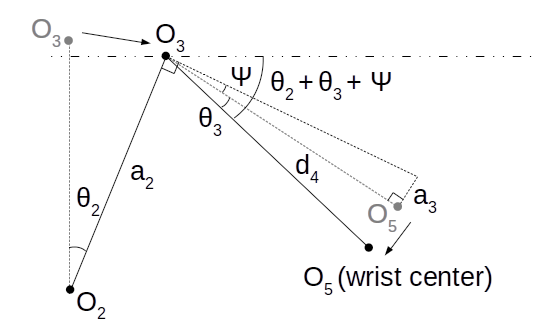

In [8]:
Image(filename='misc_images/position_kinematics_123.png')
# The sign of the angle follows the right-hand-rule with z-axis pointing into the plane of the paper

In [9]:
def check_solution(theta2, theta3, psi, px, py, pz):
    """Check the correctness of theta2 and theta3"""
    l1 = A2*np.sin(theta2) + np.sqrt(D4**2 + A3**2)*np.cos(theta2 + theta3 + psi)
    r1 = np.sqrt(px**2 + py**2) - A1
    l2 = A2*np.cos(theta2) - np.sqrt(D4**2 + A3**2)*np.sin(theta2 + theta3 + psi)
    r2 = pz - D1
    if abs(l1 - r1) < 1e-6 and abs(l2 - r2) < 1e-6:
        return True
    else:
        return False
    

def solve_position_kinematics(px_wc, py_wc, pz_wc):
    """Solve the position kinematics for the first three joints
    
    @param px_wc, py_wc, pz_wc: float
        Coordinates of the spherical wrist center (link5)
        Note: in practical case, these coordinates should be derived 
        from the position and orientation of the end effector.
        
    @return theta1, theta2, theta3: float
        Theta angles in the DH coordinate systems for the first
        three joints.
    """
    pr_wc = np.sqrt(px_wc**2 + py_wc**2)

    ######################################################
    # Calculate joint angles using Geometric IK method
    ######################################################

    # calculate the twist angles of the first three joints
    theta1 = np.arctan2(py_wc, px_wc)

    #
    # theta2 and theta3 are the solution of the following two equations:
    # (see the above plot)
    #
    # A2*sin(theta2) + (D4**2 + A3**2)^0.5*cos(theta2 + theta3 + psi) = sqrt(px_wc^2 + py_wc^2) - A1
    # A2*cos(theta2) - (D4**2 + A3**2)^0.5*sin(theta2 + theta3 + psi) = pz_wc - D1
    #
    psi = np.arctan2(A3, D4)
    R4 = np.sqrt(D4**2 + A3**2)

    sin_theta3_plus_psi = (A2**2 + R4**2 - (pr_wc - A1)**2 - (pz_wc - D1)**2)/(2*A2*R4)
    cos_theta3_plus_psi = np.sqrt(1 - sin_theta3_plus_psi**2)
    possible_theta3 = np.array([np.arctan2(sin_theta3_plus_psi, cos_theta3_plus_psi) - psi,
                                np.arctan2(sin_theta3_plus_psi, -cos_theta3_plus_psi) - psi])

    sin_theta2 = ((pr_wc - A1)*(A2 - R4*np.sin(possible_theta3 + psi)) - 
                  (pz_wc - D1)*R4*np.cos(possible_theta3 + psi)) / \
                 ((A2 - R4*np.sin(possible_theta3 + psi))**2 +
                  (R4*np.cos(possible_theta3 + psi))**2)
    cos_theta2 = np.sqrt(1 - sin_theta2**2)
    possible_theta2 = np.concatenate([np.arctan2(sin_theta2, cos_theta2),
                                      np.arctan2(sin_theta2, -cos_theta2)])

    # There are four possible solutions
    possible_solution = ((possible_theta2[0], possible_theta3[0]),
                         (possible_theta2[1], possible_theta3[1]),
                         (possible_theta2[2], possible_theta3[0]),
                         (possible_theta2[3], possible_theta3[1]))

    # Only two of them are the true solutions
    solution = []
    for slt in possible_solution:
        theta2 = slt[0]
        theta3 = slt[1]
        if check_solution(theta2, theta3, psi, px_wc, py_wc, pz_wc) is True:
            solution.append(slt)

    if len(solution) == 0:
        print("Failed to find a solution!")
        return theta1, 0., 0.
    else:
        assert(len(solution) == 2)  # should be two solutions
        
        # We will choose the solution with smaller rotation angles to 
        # avoid reaching limitations of joints.
        if solution[0][0]**2 + solution[0][1]**2 < solution[1][0]**2 + solution[1][1]**2:
            return theta1, solution[0][0], solution[0][1]
        else:
            return theta1, solution[1][0], solution[1][1]

    
# Use 'tht' here to avoid conflicting with the predefined symbol 'theta1-6'    
tht1, tht2, tht3 = solve_position_kinematics(1.9894, 0.73496, 2.4322)   
print("The solution is: theta1 = {}, theta2 = {}, theta3 = {}".format(tht1, tht2, tht3))

The solution is: theta1 = 0.353885520987, theta2 = 0.283251157559, theta3 = -0.646160246916


### Overall orientation kinematics

In [10]:
### Symbolic transfer matrix T3_G
print(simplify(T3_4*T4_5*T5_6*T6_G*Rz_corr*Ry_corr)[:3, :3])

Matrix([
[-sin(theta5)*cos(theta4),  sin(theta4)*cos(theta6) + sin(theta6)*cos(theta4)*cos(theta5), -sin(theta4)*sin(theta6) + cos(theta4)*cos(theta5)*cos(theta6)],
[             cos(theta5),                                        sin(theta5)*sin(theta6),                                        sin(theta5)*cos(theta6)],
[ sin(theta4)*sin(theta5), -sin(theta4)*sin(theta6)*cos(theta5) + cos(theta4)*cos(theta6), -sin(theta4)*cos(theta5)*cos(theta6) - sin(theta6)*cos(theta4)]])


In [11]:
# Position and orientation of the end-effector (here the gripper link) obtained from Rviz
roll, pitch, yaw = euler_from_quaternion((-0.46166, -0.028333, 0.35717, 0.81148))

# Rotation matrix from the base to the end-effector
trans0_G = xyz_fixed_angle(roll, pitch, yaw)[:3, :3]

px = 2.0586
py = 0.86089
pz = 2.1606

# coordinates of the spherical wrist center
dp = DG*np.matmul(trans0_G, np.array([1, 0, 0]))
px_wc = px - dp[0, 0]
py_wc = py - dp[0, 1]
pz_wc = pz - dp[0, 2]
px_wc, py_wc, pz_wc

# obtain thetas for the first three joints
tht1, tht2, tht3 = solve_position_kinematics(1.8334, 0.67732, 2.2466)
trans0_3 = trans_base_link3(tht1, tht2, tht3)[:3, :3]

# The inverse matrix of R0_3 is its transpose matrix
trans3_G = np.matmul(trans0_3.T, trans0_G)

# r11 = -sin(theta5)*cos(theta4)
# r31 = sin(theta5)*sin(theta4)
tht4 = np.arctan2(trans3_G[2, 0], -trans3_G[0, 0])

# r22 = sin(theta5)*sin(theta6)
# r23 = sin(theta5)*cos(theta6)
tht6 = np.arctan2(trans3_G[1, 1], trans3_G[1, 2])

# r12 = cos(theta5)
# There are two possible solutions for theta5, but only one of them is correct
tht5 = np.arctan2(np.sqrt(1 - trans3_G[1, 0]**2), trans3_G[1, 0])
if np.abs(np.sin(tht5)*np.sin(tht6) - trans3_G[1, 1]) < 1e-6 and \
        np.abs(np.sin(tht5)*np.cos(tht6) - trans3_G[1, 2]) < 1e-6:
    pass
else:
    tht5 = np.arctan2(-np.sqrt(1 - trans3_G[1, 0]**2), trans3_G[1, 0])
    if np.abs(np.sin(tht5)*np.sin(tht6) - trans3_G[1, 1]) < 1e-6 and \
            np.abs(np.sin(tht5)*np.cos(tht6) - trans3_G[1, 2]) < 1e-6:
        pass
    else:
        print("Warning: Not found! Solution for theta5!")
        
print("The solution is: \ntheta1 = {}, theta2 = {}, theta3 = {}\n"
      "theta4 = {}, theta5 = {}, theta6 = {}".format(tht1, tht2, tht3, tht4, tht5, tht6))


The solution is: 
theta1 = 0.353881840558, theta2 = 0.100162283215, theta3 = -0.305421560931
theta4 = 0.59133392072, theta5 = 0.59122678248, theta6 = -1.53694751612


In [12]:
# print out position errors
prediction = trans_base_linkg(tht1, tht2, tht3, tht4, tht5, tht6)
print("px error: {:.4e}, py error {:.4e}, pz error {:.4e}".
      format(prediction[0, 3] - px, prediction[1, 3] - py, prediction[2, 3] - pz))

px error: 6.0870e-06, py error -3.1211e-06, pz error 9.1903e-06


The errors in real run are even smaller!